In [1]:
import sys
sys.path.append("..")
import random
from tqdm import tqdm

In [2]:
import dataset
from dataset.cityscapes import Cityscapes
import torchvision
from dataset import transform
import numpy as np
import PIL
from PIL import Image
import time
import torch

In [3]:
from utils import color_map, Label2Color
clm = color_map('cts')
lbl2color = Label2Color(clm)
lbl2cl = lambda img : PIL.Image.fromarray(lbl2color(img))
toimg = torchvision.transforms.ToPILImage()

classes = dataset.cityscapes.map_classes
classes

{7: 'road',
 8: 'sidewalk',
 9: 'parking',
 10: 'rail truck',
 11: 'building',
 12: 'wall',
 13: 'fence',
 14: 'guard_rail',
 15: 'bridge',
 16: 'tunnel',
 17: 'pole',
 18: 'pole_group',
 19: 'light',
 20: 'sign',
 21: 'vegetation',
 22: 'terrain',
 23: 'sky',
 24: 'person',
 25: 'rider',
 26: 'car',
 27: 'truck',
 28: 'bus',
 29: 'caravan',
 30: 'trailer',
 31: 'train',
 32: 'motocycle',
 33: 'bicycle'}

In [4]:
from collections import namedtuple

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [5]:
t_transform = transform.ToTensor()
# transform.Compose([
#         transform.ToTensor(),
#         transform.Normalize(mean=[0.485, 0.456, 0.406],
#                             std=[0.229, 0.224, 0.225]),
#     ])

In [8]:
data = Cityscapes('../data', train=True, transform=t_transform, cl19=False)
dlen = len(data)

In [22]:
data = Cityscapes('../data', train=True, transform=t_transform, cl19=False)
#excluded_cls = [27,28,31,32] # 1098 excluded
#excluded_cls = [31,32] # 637 excluded
#excluded_cls = [28,29,30,31] # 518 excluded

count_r = 0
class_to_idx = {x:[] for x in range(34)}
for i in tqdm(range(len(data))):
    cls = data[i][1].unique()
    for cl in cls:
        class_to_idx[cl.item()].append(i) # append the index!
    if any([x in excluded_cls for x in cls]):
        count_r += 1

count_t = [len(class_to_idx[i]) for i in range(0,34)]
for i in range(7,34):
    print(f"{i:2}-{labels[i].name:15}: {count_t[i]:8.0f} /  {count_t[i]*100/len(data):4.1f}")
    

100%|██████████| 2975/2975 [04:55<00:00, 10.06it/s]

 7-road           :     2934 /  98.6
 8-sidewalk       :     2811 /  94.5
 9-parking        :      720 /  24.2
10-rail track     :      101 /   3.4
11-building       :     2934 /  98.6
12-wall           :      970 /  32.6
13-fence          :     1296 /  43.6
14-guard rail     :       19 /   0.6
15-bridge         :      233 /   7.8
16-tunnel         :       25 /   0.8
17-pole           :     2949 /  99.1
18-polegroup      :      223 /   7.5
19-traffic light  :     1658 /  55.7
20-traffic sign   :     2808 /  94.4
21-vegetation     :     2891 /  97.2
22-terrain        :     1654 /  55.6
23-sky            :     2686 /  90.3
24-person         :     2343 /  78.8
25-rider          :     1023 /  34.4
26-car            :     2832 /  95.2
27-truck          :      359 /  12.1
28-bus            :      274 /   9.2
29-caravan        :       59 /   2.0
30-trailer        :       72 /   2.4
31-train          :      142 /   4.8
32-motorcycle     :      513 /  17.2
33-bicycle        :     1646 /  55.3


In [23]:
#excluded_cls = [32,33] # 1817 excluded
#excluded_cls = [25,32,33] # 1841 excluded
#excluded_cls = [27,28,31] # 494 excluded
excluded_cls = [27,28,29,30,31] # 815 excluded

print(excluded_cls)

idxs = set(range(dlen))
for cl, img_set in class_to_idx.items():
    if cl in excluded_cls:
        idxs = idxs.difference(img_set)
idxs = list(idxs)
print(len(idxs))
print(f"Excluded {dlen - len(idxs)} images") 

[27, 28, 29, 30, 31]
2160
Excluded 815 images


In [ ]:
red_cls_to_idxs = {x:[] for x in range(0,90)}
mini = 200000
avg = 0
cnt = 0

for c in range(0,91):
    red_cls_to_idxs[c] = set(class_to_idx[c]).intersection(idxs)
    a = len(red_cls_to_idxs[c])
    if a != 0:
        if mini > a:
            mini = a
        avg += a
        cnt += 1
avg = avg/cnt

# Objects occurencies 
for c in range(0,91):
    print(f"{c:2}: {len(red_cls_to_idxs[c]):8.0f}")
print(f"minimum is {mini}")
print(f"average is {avg} of {cnt} classes")

In [24]:
import pickle

a = {x: class_to_idx[x] for x in (dataset.cityscapes.eval_classes + [29,30])}
print(a.keys())

path = '../data/cityscapes/split/inverse_dict_train.pkl'
with open(path, 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path, 'rb') as handle:
    class_to_idx = pickle.load(handle)

len(class_to_idx[7])

dict_keys([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 29, 30])


2934

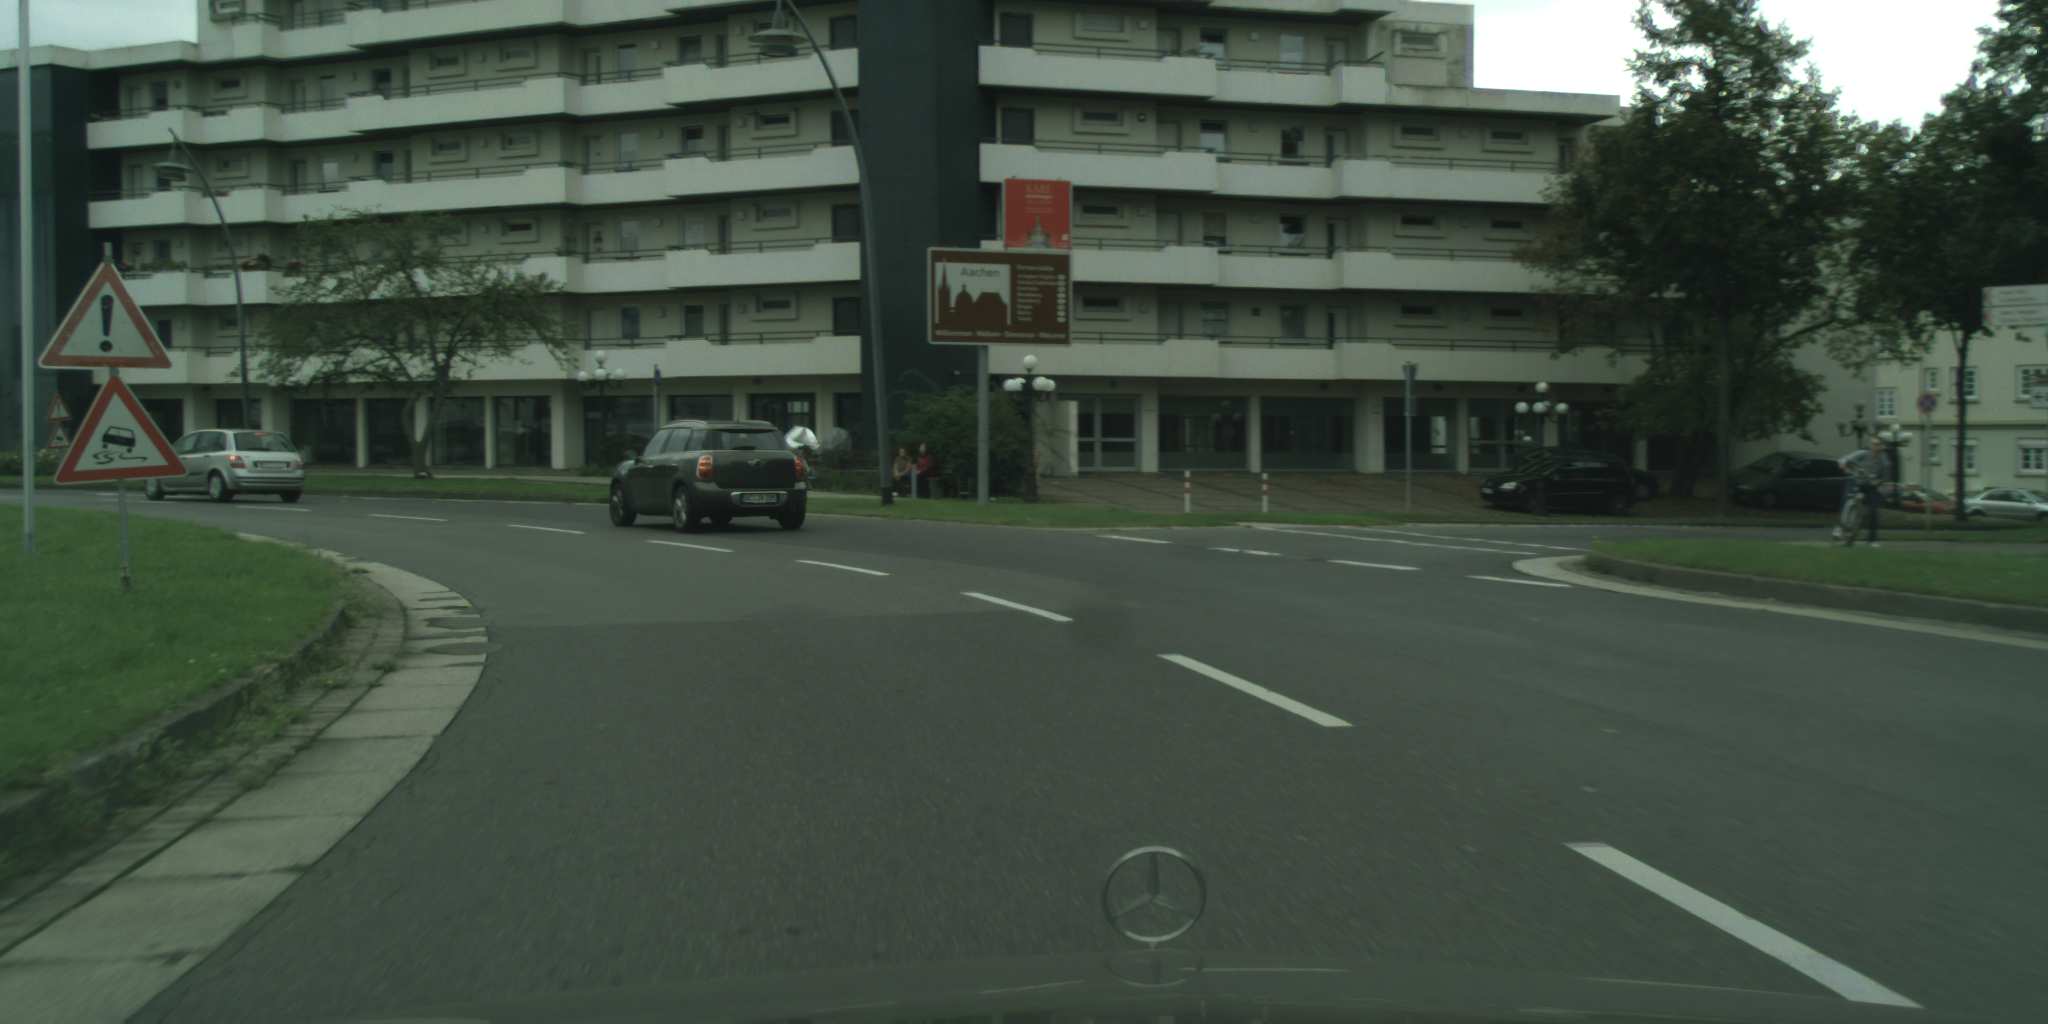

In [26]:
toimg(data[class_to_idx[7][0]][0]) 